<a href="https://colab.research.google.com/github/alscop/ESAA-25-2/blob/main/LGBM_XGB_Cat_%EB%AA%A8%EB%8D%B8_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')

In [5]:
DATE_COL   = '영업일자'
TARGET_COL = '매출수량'
KEY_COLS   = ['영업장명', '메뉴명']

# 첫번째 '_' 기준으로 분리
train[KEY_COLS] = train['영업장명_메뉴명'].str.split('_', n=1, expand=True)

In [6]:
import pandas as pd

# 1. [가장 중요] 날짜 데이터 형식 변환을 제일 먼저 수행해야 합니다.
train['영업일자'] = pd.to_datetime(train['영업일자'])

# 2. 기본 날짜 피처 추출 (이제 .dt 접근자 사용 가능)
train['요일'] = train['영업일자'].dt.dayofweek
train['연도'] = train['영업일자'].dt.year
train['월'] = train['영업일자'].dt.month
train['일'] = train['영업일자'].dt.day
train['주'] = train['영업일자'].dt.isocalendar().week.astype(int)

# 3. 주말 여부 생성
# (질문자님의 의도대로 금(4), 토(5), 일(6)을 주말로 설정)
train['주말여부'] = (train['요일'] >= 4).map({True: '주말', False: '주중'})

# 4. 공휴일 설정 (양력 - 매년 고정)
holis = ['01-01', '03-01', '05-05', '06-06', '08-15', '10-03', '10-09', '12-25']
train['공휴일여부'] = train['영업일자'].dt.strftime('%m-%d').isin(holis).astype(int)

# 5. 음력 공휴일 설정 (설날, 추석 등 - 변동 날짜)
lunar_holidays = [
    '2023-01-21', '2023-01-22', '2023-01-23',
    '2023-09-28', '2023-09-29', '2023-09-30',
    '2024-02-09', '2024-02-10', '2024-02-11',
]
train['음력공휴일여부'] = train['영업일자'].dt.strftime('%Y-%m-%d').isin(lunar_holidays).astype(int)

# 6. 대체 및 기타 공휴일 설정 (선거일 등)
substitute_holidays = [
    '2023-01-24', '2023-05-29', '2023-10-02',
    '2024-02-12', '2024-04-10', '2024-05-06'
]
train['대체공휴일여부'] = train['영업일자'].dt.strftime('%Y-%m-%d').isin(substitute_holidays).astype(int)

# 7. 전체 공휴일 통합 (하나라도 해당하면 1)
train['전체공휴일여부'] = ((train['공휴일여부'] == 1) |
                         (train['음력공휴일여부'] == 1) |
                         (train['대체공휴일여부'] == 1)).astype(int)

# 결과 확인
print(train[['영업일자', '요일', '주말여부', '전체공휴일여부']].head())

        영업일자  요일 주말여부  전체공휴일여부
0 2023-01-01   6   주말        1
1 2023-01-02   0   주중        0
2 2023-01-03   1   주중        0
3 2023-01-04   2   주중        0
4 2023-01-05   3   주중        0


In [7]:
# 1. 데이터를 날짜순으로 정렬 (과거 평균을 구하기 위해 필수)
train = train.sort_values('영업일자')

# 2. 월요일 데이터만 추출해서 '누적 과거 평균' 계산
mon_data = train[train['요일'] == 0].copy()
# expanding().mean()은 현재 행 이전까지의 모든 데이터 평균을 구합니다.
# 단, 현재 날짜의 매출이 포함되지 않게 shift(1)을 해줍니다.
mon_data['past_mon_mean'] = mon_data['매출수량'].expanding().mean().shift(1)

# 3. 원본 데이터에 과거 평균값 합치기
train = pd.merge(train, mon_data[['영업일자', 'past_mon_mean']], on='영업일자', how='left')

# 4. 지수 계산: (현재 매출) / (과거 월요일들의 평균)
# 첫 번째 월요일은 과거 데이터가 없으므로 결측치가 생길 수 있어 fillna(1) 처리
train['mon_event_intensity'] = (train['매출수량'] / train['past_mon_mean']).fillna(1.0)

# 확인
print(train[train['요일']==0][['영업일자', '매출수량', 'past_mon_mean', 'mon_event_intensity']].head())



# 월별 메뉴별 총 판매량 집계부터
train_clean = train[train['매출수량'] >= 0].copy()
monthly_agg = train_clean.groupby(['연도', '월', '영업장명', '메뉴명'])['매출수량'].sum().reset_index()
monthly_agg.rename(columns={'매출수량': '월간_메뉴_총판매량'}, inplace=True)

# 월별 전체 판매량 계산 후 구성비 계산
total_monthly_sales = monthly_agg.groupby(['연도', '월', '영업장명'])['월간_메뉴_총판매량'].transform('sum')
monthly_agg['메뉴_비중'] = monthly_agg['월간_메뉴_총판매량'] / total_monthly_sales

# 월별 판매 순위 생성
# 동일할 경우 'min' 방식으로 매김
monthly_agg['메뉴_판매순위'] = monthly_agg.groupby(['연도', '월', '영업장명'])['월간_메뉴_총판매량'].rank(ascending=False, method='min')

# 전월 대비 구성비의 증감폭
# 메뉴별로 시계열 순서에 따라 이전 행과의 차이 계산
monthly_agg = monthly_agg.sort_values(['영업장명', '메뉴명', '연도', '월'])
monthly_agg['비중_증감폭'] = monthly_agg.groupby(['영업장명', '메뉴명'])['메뉴_비중'].diff().fillna(0)


# 기존 데이터프레임에 결합
# '영업장명'과 '메뉴명'을 키로 각 일자별 데이터에 매칭
train_clean = train[train['매출수량'] >= 0].copy()
df_final = pd.merge(train_clean,
                    monthly_agg[['연도', '월', '영업장명', '메뉴명', '메뉴_비중', '메뉴_판매순위', '비중_증감폭']],
                    on=['연도', '월', '영업장명', '메뉴명'], how='left')


def add_detailed_off_status(df, window=7):
    # 분석의 정확성을 위해 날짜순 정렬
    df = df.sort_values(['영업장명', '영업일자'])
    df['휴점여부'] = 0

    # 영업장별로 루프를 돌며 판단 (해당 영업장이 문 닫으면 모든 메뉴 판매량이 0이 될 것을 가정함)
    for shop in df['영업장명'].unique():
        # 해당 영업장의 일자별 총 매출 수량 계산
        shop_daily = df[df['영업장명'] == shop].groupby('영업일자')['매출수량'].sum().reset_index()

        # window 기간 동안 매출 합계가 0인지 확인
        is_zero = shop_daily['매출수량'] == 0
        rolling_zero = is_zero.rolling(window=window).sum() == window

        # 휴점으로 판단된 날짜들 추출
        off_dates = shop_daily.loc[rolling_zero, '영업일자']

        # 원본 데이터프레임에 반영 - 특정 날짜에 해당 영업장의 모든 메뉴 행을 휴점으로 표시
        for off_date in off_dates:
            # rolling이 끝나는 지점부터 역으로 window만큼 휴점 처리
            start_date = off_date - pd.Timedelta(days=window-1)
            mask = (df['영업장명'] == shop) & (df['영업일자'] >= start_date) & (df['영업일자'] <= off_date)
            df.loc[mask, '휴점여부'] = 1

    return df

# 적용
df_final = add_detailed_off_status(df_final)

          영업일자  매출수량  past_mon_mean  mon_event_intensity
193 2023-01-02    17            NaN             1.000000
194 2023-01-02    17      17.000000             1.000000
195 2023-01-02    17       8.500000             2.000000
196 2023-01-02    17       5.666667             3.000000
197 2023-01-02    17       4.500000             3.777778


In [8]:
# 업장 유형 파생변수 생성(범주형)
flow_stores = ['포레스트릿', '화담숲주막', '화담숲카페', '카페테리아']

train['store_type'] = np.where(
    train['영업장명'].isin(flow_stores),
    'flow',      # 유동형
    'normal'     # 일반 식음
)

# 타깃 변환
train['매출수량_log1p'] = np.log1p(train['매출수량'])

# 메뉴 활동성
menu_sell_rate = (
    train.groupby(['영업장명','메뉴명'])['매출수량']
         .apply(lambda x: (x > 0).mean())
         .reset_index(name='sell_rate')
)

train = train.merge(menu_sell_rate, on=['영업장명','메뉴명'], how='left')

# 메뉴X업장 기준 lag 변수
group_cols = ['영업장명', '메뉴명']
target = '매출수량'

for lag in [1, 7, 14]:
    train[f'lag_{lag}'] = (
        train
        .groupby(group_cols)[target]
        .shift(lag)
    )

# 단기 노이즈 제거 + 추세 반영
# Rolling 평균
for win in [3, 7, 14]:
    train[f'roll_{win}_mean'] = (
        train
        .groupby(group_cols)[target]
        .shift(1)
        .rolling(win)
        .mean()
    )

# Rolling 표준편차
train['roll_7_std'] = (
    train
    .groupby(group_cols)[target]
    .shift(1)
    .rolling(7)
    .std()
)

# 스파이크 감지(지난주 대비 증감)
train['diff_1'] = train['lag_1'] - train['lag_7']

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder

def preprocess_menu_data(train: pd.DataFrame):
    train = train.copy()

    # ---------------------------------------------------------
    # 메뉴 카테고리화
    def categorize_menu(name):
        name = str(name).lower().replace(" ", "")

        categories = {
            '행사/단체': ['단체', '연회', 'conference', 'ballroom', 'convention', 'opus', 'hall', 'platter', '패키지', '세트', 'openfood', '오픈푸드', '무제한', '뷔페', '정식'],
            '대여/공간': ['대여', '이용료', '렌탈', '의자', '룸', '잔디그늘집'],
            '주류': ['소주', '맥주', '와인', '막걸리', '하이볼', '칵테일', '카스', '테라', '참이슬', '처음처럼', '하이네켄', '버드와이저', '스텔라', '복분자', 'beer', 'wine', 'gls', 'bottle', '샷'],
            '음료/카페': ['아메리카노', '라떼', '에이드', '주스', '식혜', '차', '커피', '티', '콜라', '사이다', '스프라이트', '미숫가루', '생수', '토닉', 'coffee'],
            '구이/BBQ': ['bbq', '삼겹', '구이', '갈비', '목살', '양갈비', '한우', '등심', '스테이크', 'aus', '돈육', '소세지', '킬바사'],
            '면류': ['파스타', '스파게티', '짜장', '짬뽕', '우동', '국수', '냉면', '라면', '소바', '알리오', '까르보나라', '메밀'],
            '국/탕/찌개': ['찌개', '탕', '국밥', '전골', '해장국', '설렁탕', '갱시기', '육개장', '미역국'],
            '분식/튀김': ['떡볶이', '튀김', '돈까스', '핫도그', '치킨', '너겟', '어묵', '순대'],
            '밥류/한식': ['비빔밥', '덮밥', '볶음밥', '리조또', '공깃밥', '햇반', '주먹밥', '김치', '된장', '반찬'],
            '디저트': ['아이스크림', '케이크', '쿠키', '빵', '와플', '빙수', '디저트', '푸딩'],
            '소모품/기타': ['컵', '종이컵', '수저', '젓가락', '접시', '일회용', '가위', '집게', '부탄가스', '쌈장', '소스', '사리', '야채추가']
        }

        for cat, keywords in categories.items():
            for kw in keywords:
                if kw in name:
                    return cat
        return '기타'

    train['메뉴_카테고리'] = train['메뉴명'].apply(categorize_menu)
    return train

def encode_features_train_only(train: pd.DataFrame):
    train = train.copy()

    le_store = LabelEncoder()
    le_menu = LabelEncoder()
    le_cat = LabelEncoder()

    # Train 데이터에 대해서만 fit_transform 수행
    train['영업장명_le'] = le_store.fit_transform(train['영업장명'].astype(str))
    train['메뉴명_le'] = le_menu.fit_transform(train['메뉴명'].astype(str))
    train['카테고리_le'] = le_cat.fit_transform(train['메뉴_카테고리'].astype(str))

    return train, le_store, le_menu, le_cat


# 전처리 수행
train = preprocess_menu_data(train)

# 인코딩
train_encoded, le_store, le_menu, le_cat = encode_features_train_only(train)

In [10]:
# 결과
print(train_encoded[['영업장명_메뉴명', '영업장명', '메뉴명', '메뉴_카테고리', '카테고리_le']].head())

             영업장명_메뉴명        영업장명            메뉴명 메뉴_카테고리  카테고리_le
0  느티나무 셀프BBQ_1인 수저세트  느티나무 셀프BBQ        1인 수저세트   행사/단체       11
1   연회장_Conference M8         연회장  Conference M8   행사/단체       11
2        미라시아_핑크레몬에이드        미라시아        핑크레몬에이드   음료/카페        9
3  라그로타_미션 서드 카베르네 쉬라        라그로타  미션 서드 카베르네 쉬라      기타        2
4          화담숲주막_병천순대       화담숲주막           병천순대   분식/튀김        7


## 제미나이가 통합본 정리해준 전처리 코드들

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder

# =========================================================
# 1. 함수 정의 (전처리용 헬퍼 함수들)
# =========================================================

def categorize_menu(name):
    """메뉴명을 기반으로 카테고리를 분류하는 함수"""
    name = str(name).lower().replace(" ", "")

    categories = {
        '행사/단체': ['단체', '연회', 'conference', 'ballroom', 'convention', 'opus', 'hall', 'platter', '패키지', '세트', 'openfood', '오픈푸드', '무제한', '뷔페', '정식'],
        '대여/공간': ['대여', '이용료', '렌탈', '의자', '룸', '잔디그늘집'],
        '주류': ['소주', '맥주', '와인', '막걸리', '하이볼', '칵테일', '카스', '테라', '참이슬', '처음처럼', '하이네켄', '버드와이저', '스텔라', '복분자', 'beer', 'wine', 'gls', 'bottle', '샷'],
        '음료/카페': ['아메리카노', '라떼', '에이드', '주스', '식혜', '차', '커피', '티', '콜라', '사이다', '스프라이트', '미숫가루', '생수', '토닉', 'coffee'],
        '구이/BBQ': ['bbq', '삼겹', '구이', '갈비', '목살', '양갈비', '한우', '등심', '스테이크', 'aus', '돈육', '소세지', '킬바사'],
        '면류': ['파스타', '스파게티', '짜장', '짬뽕', '우동', '국수', '냉면', '라면', '소바', '알리오', '까르보나라', '메밀'],
        '국/탕/찌개': ['찌개', '탕', '국밥', '전골', '해장국', '설렁탕', '갱시기', '육개장', '미역국'],
        '분식/튀김': ['떡볶이', '튀김', '돈까스', '핫도그', '치킨', '너겟', '어묵', '순대'],
        '밥류/한식': ['비빔밥', '덮밥', '볶음밥', '리조또', '공깃밥', '햇반', '주먹밥', '김치', '된장', '반찬'],
        '디저트': ['아이스크림', '케이크', '쿠키', '빵', '와플', '빙수', '디저트', '푸딩'],
        '소모품/기타': ['컵', '종이컵', '수저', '젓가락', '접시', '일회용', '가위', '집게', '부탄가스', '쌈장', '소스', '사리', '야채추가']
    }

    for cat, keywords in categories.items():
        for kw in keywords:
            if kw in name:
                return cat
    return '기타'

def add_detailed_off_status(df, window=7):
    """7일 연속 매출 0인 경우 휴점으로 판단"""
    df = df.copy()
    # 날짜순 정렬 필수
    df = df.sort_values(['영업장명', '영업일자'])
    df['휴점여부'] = 0

    for shop in df['영업장명'].unique():
        shop_mask = df['영업장명'] == shop
        shop_daily = df[shop_mask].groupby('영업일자')['매출수량'].sum().reset_index()

        is_zero = shop_daily['매출수량'] == 0
        rolling_zero = is_zero.rolling(window=window).sum() == window
        off_dates = shop_daily.loc[rolling_zero, '영업일자']

        for off_date in off_dates:
            start_date = off_date - pd.Timedelta(days=window-1)
            # 해당 기간 마스킹
            mask = (df['영업장명'] == shop) & (df['영업일자'] >= start_date) & (df['영업일자'] <= off_date)
            df.loc[mask, '휴점여부'] = 1

    return df

def encode_features_train_only(train_df):
    """라벨 인코딩 수행"""
    df = train_df.copy()
    le_store = LabelEncoder()
    le_menu = LabelEncoder()
    le_cat = LabelEncoder()

    df['영업장명_le'] = le_store.fit_transform(df['영업장명'].astype(str))
    df['메뉴명_le'] = le_menu.fit_transform(df['메뉴명'].astype(str))
    df['카테고리_le'] = le_cat.fit_transform(df['메뉴_카테고리'].astype(str))

    return df, le_store, le_menu, le_cat

# =========================================================
# 2. 메인 전처리 실행
# =========================================================

# 1) 데이터 로드
train = pd.read_csv('train.csv')

# 2) 텍스트 정제 및 업장/메뉴명 분리
train['영업장명_메뉴명'] = train['영업장명_메뉴명'].astype(str).str.replace(r"\ufeff|\u200b", "", regex=True)
train['영업장명_메뉴명'] = train['영업장명_메뉴명'].str.replace("\xa0", " ", regex=False).str.strip()
split_data = train['영업장명_메뉴명'].str.split('_', n=1, expand=True)
train['영업장명'] = split_data[0].str.strip()
train['메뉴명'] = split_data[1].str.strip() if split_data.shape[1] > 1 else "미상"

# 3) 날짜 형식 변환 및 기본 날짜 피처
train['영업일자'] = pd.to_datetime(train['영업일자'])
train['연도'] = train['영업일자'].dt.year
train['월'] = train['영업일자'].dt.month
train['일'] = train['영업일자'].dt.day
train['요일'] = train['영업일자'].dt.dayofweek
train['주'] = train['영업일자'].dt.isocalendar().week.astype(int)

# 4) 공휴일 및 주말 정보 생성
train['주말여부'] = (train['요일'] >= 4).map({True: '주말', False: '주중'})

holis = ['01-01', '03-01', '05-05', '06-06', '08-15', '10-03', '10-09', '12-25']
lunar_holidays = ['2023-01-21', '2023-01-22', '2023-01-23', '2023-09-28', '2023-09-29', '2023-09-30', '2024-02-09', '2024-02-10', '2024-02-11']
substitute_holidays = ['2023-01-24', '2023-05-29', '2023-10-02', '2024-02-12', '2024-04-10', '2024-05-06']

train['공휴일여부'] = train['영업일자'].dt.strftime('%m-%d').isin(holis).astype(int)
train['음력공휴일여부'] = train['영업일자'].dt.strftime('%Y-%m-%d').isin(lunar_holidays).astype(int)
train['대체공휴일여부'] = train['영업일자'].dt.strftime('%Y-%m-%d').isin(substitute_holidays).astype(int)
train['전체공휴일여부'] = ((train['공휴일여부'] == 1) | (train['음력공휴일여부'] == 1) | (train['대체공휴일여부'] == 1)).astype(int)

# 5) 정렬 (시계열 연산을 위해 필수)
train = train.sort_values(['영업장명', '메뉴명', '영업일자'])

# 6) 월요일 과거 평균 (Expanding Mean)
mon_data = train[train['요일'] == 0].copy()
mon_data['past_mon_mean'] = mon_data.groupby(['영업장명', '메뉴명'])['매출수량'].expanding().mean().shift(1).reset_index(level=[0,1], drop=True)
train = pd.merge(train, mon_data[['영업일자', '영업장명', '메뉴명', 'past_mon_mean']], on=['영업일자', '영업장명', '메뉴명'], how='left')
train['mon_event_intensity'] = (train['매출수량'] / train['past_mon_mean']).fillna(1.0)

# 7) 월별 집계 통계 (비중, 순위 등)
# 주의: 원본 코드의 로직을 유지하되, train 데이터프레임에 병합
monthly_agg = train.groupby(['연도', '월', '영업장명', '메뉴명'])['매출수량'].sum().reset_index()
monthly_agg.rename(columns={'매출수량': '월간_메뉴_총판매량'}, inplace=True)
total_monthly_sales = monthly_agg.groupby(['연도', '월', '영업장명'])['월간_메뉴_총판매량'].transform('sum')
monthly_agg['메뉴_비중'] = monthly_agg['월간_메뉴_총판매량'] / (total_monthly_sales + 1e-9) # 0나누기 방지
monthly_agg['메뉴_판매순위'] = monthly_agg.groupby(['연도', '월', '영업장명'])['월간_메뉴_총판매량'].rank(ascending=False, method='min')
monthly_agg = monthly_agg.sort_values(['영업장명', '메뉴명', '연도', '월'])
monthly_agg['비중_증감폭'] = monthly_agg.groupby(['영업장명', '메뉴명'])['메뉴_비중'].diff().fillna(0)

train = pd.merge(train, monthly_agg[['연도', '월', '영업장명', '메뉴명', '메뉴_비중', '메뉴_판매순위', '비중_증감폭']],
                 on=['연도', '월', '영업장명', '메뉴명'], how='left')

# 8) 휴점 여부 및 업장 타입
train = add_detailed_off_status(train)
flow_stores = ['포레스트릿', '화담숲주막', '화담숲카페', '카페테리아']
train['store_type'] = np.where(train['영업장명'].isin(flow_stores), 'flow', 'normal')

# 9) 메뉴 카테고리 및 활동성 지표
train['메뉴_카테고리'] = train['메뉴명'].apply(categorize_menu)
train['매출수량_log1p'] = np.log1p(train['매출수량'])

menu_sell_rate = train.groupby(['영업장명','메뉴명'])['매출수량'].apply(lambda x: (x > 0).mean()).reset_index(name='sell_rate')
train = train.merge(menu_sell_rate, on=['영업장명','메뉴명'], how='left')

# 10) 시계열 Lag 및 Rolling 변수 (다시 정렬 후 수행)
train = train.sort_values(['영업장명', '메뉴명', '영업일자'])
group_cols = ['영업장명', '메뉴명']
target = '매출수량'

for lag in [1, 7, 14]:
    train[f'lag_{lag}'] = train.groupby(group_cols)[target].shift(lag)

for win in [3, 7, 14]:
    train[f'roll_{win}_mean'] = train.groupby(group_cols)[target].shift(1).rolling(win).mean()

train['roll_7_std'] = train.groupby(group_cols)[target].shift(1).rolling(7).std()
train['diff_1'] = train['lag_1'] - train['lag_7']

# 11) 결측치 처리 (Lag로 인한 NaN 채우기)
train = train.fillna(0)

# 12) 라벨 인코딩 (최종)
train_encoded, le_store, le_menu, le_cat = encode_features_train_only(train)

# 결과 확인
print("전처리 완료! 데이터 크기:", train_encoded.shape)
print(train_encoded[['영업일자', '영업장명', '메뉴명', '휴점여부', '매출수량_log1p', '카테고리_le']].head())

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


전처리 완료! 데이터 크기: (102676, 36)
         영업일자        영업장명      메뉴명  휴점여부  매출수량_log1p  카테고리_le
0  2023-01-01  느티나무 셀프BBQ  1인 수저세트     0         0.0       11
23 2023-01-02  느티나무 셀프BBQ  1인 수저세트     0         0.0       11
46 2023-01-03  느티나무 셀프BBQ  1인 수저세트     0         0.0       11
69 2023-01-04  느티나무 셀프BBQ  1인 수저세트     0         0.0       11
92 2023-01-05  느티나무 셀프BBQ  1인 수저세트     0         0.0       11


In [12]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102676 entries, 0 to 102675
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   영업일자                 102676 non-null  datetime64[ns]
 1   영업장명_메뉴명             102676 non-null  object        
 2   매출수량                 102676 non-null  int64         
 3   영업장명                 102676 non-null  object        
 4   메뉴명                  102676 non-null  object        
 5   연도                   102676 non-null  int32         
 6   월                    102676 non-null  int32         
 7   일                    102676 non-null  int32         
 8   요일                   102676 non-null  int32         
 9   주                    102676 non-null  int64         
 10  주말여부                 102676 non-null  object        
 11  공휴일여부                102676 non-null  int64         
 12  음력공휴일여부              102676 non-null  int64         
 13  대체공휴일여부            

# 단일모델 모델링

## LGBM


In [21]:
# '주말여부' 컬럼의 한글 데이터를 숫자로 매핑
# '주말'은 1, '평일'은 0으로 변환 (기존 데이터 값에 맞춰 수정 가능)
train_encoded['주말여부'] = train_encoded['주말여부'].map({'주말': 1, '평일': 0}).fillna(0).astype(int)

# 나머지 object 타입 컬럼들도 학습에서 확실히 제외하기 위해 리스트 재확인
drop_cols = ['영업일자', '영업장명_메뉴명', '영업장명', '메뉴명', 'store_type', '메뉴_카테고리', '매출수량', '매출수량_log1p']
cat_features = ['영업장명_le', '메뉴명_le', '카테고리_le', '요일', '주말여부', '공휴일여부', '휴점여부']

train_encoded['주말여부'] = train_encoded['주말여부'].map({'주말': 1, '평일': 0}).fillna(0).astype(int)

In [14]:
!pip install Optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 11.3 MB/s eta 0:00:00


In [19]:
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.metrics import make_scorer

# 1. 평가 산식 (Weighted SMAPE) 정의
def weighted_smape(preds, train_data):
    labels = train_data.get_label()
    # 실제값 0인 경우 제외 (산식 조건)
    mask = labels != 0
    labels = labels[mask]
    preds = preds[mask]

    # SMAPE 계산
    smape = np.mean(2.0 * np.abs(preds - labels) / (np.abs(labels) + np.abs(preds))) * 100

    # 업장별 가중치는 모델 학습 후 평가 단계에서 업장별로 따로 계산하여 합산해야 함
    # 여기서는 최적화를 위한 기초 SMAPE 반환
    return 'smape', smape, False

# 2. 범주형 변수 설정
# 앞서 라벨인코딩한 컬럼들을 리스트로 지정
cat_features = ['영업장명', '메뉴명', '요일', '주말여부', '휴점여부']
for col in cat_features:
    df_final[col] = df_final[col].astype('category')

In [22]:
import optuna
import numpy as np
import lightgbm as lgb

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1)
    }

    # 데이터 정렬 및 분할 (시계열 기준)
    df_sorted = train_encoded.sort_values('영업일자')

    X = df_sorted.drop(columns=drop_cols)
    y = df_sorted['매출수량']

    # 마지막 20%를 검증 데이터로 사용
    split_idx = int(len(X) * 0.8)
    X_train, X_valid = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_valid = y.iloc[:split_idx], y.iloc[split_idx:]

    gbm = lgb.LGBMRegressor(**param)

    gbm.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='rmse',
        categorical_feature=cat_features,
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

    preds = gbm.predict(X_valid)

    # 가중치 SMAPE 계산 준비 (실제값 0 제외)
    mask = y_valid != 0
    actual = y_valid[mask]
    predict = np.maximum(preds[mask], 0)

    # 가중치가 적용되지 않은 순수 SMAPE (최적화 지표)
    smape_val = np.mean(2.0 * np.abs(actual - predict) / (np.abs(actual) + np.abs(predict)))

    return smape_val

# 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('최적 파라미터:', study.best_trial.params)

[I 2026-01-28 14:34:38,962] A new study created in memory with name: no-name-281ff605-2c15-4b95-8b3e-deb74b77654b


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.6599


[I 2026-01-28 14:34:42,591] Trial 0 finished with value: 0.6051888017368664 and parameters: {'lambda_l1': 0.01975522206786433, 'lambda_l2': 1.5219184891622827e-06, 'num_leaves': 155, 'feature_fraction': 0.8261124537010678, 'bagging_fraction': 0.6435501027508963, 'bagging_freq': 4, 'min_child_samples': 37, 'learning_rate': 0.01817512976722066}. Best is trial 0 with value: 0.6051888017368664.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.7147


[I 2026-01-28 14:34:47,764] Trial 1 finished with value: 0.610357385718721 and parameters: {'lambda_l1': 0.00023879189248883565, 'lambda_l2': 0.04856035017366093, 'num_leaves': 151, 'feature_fraction': 0.5273028606525071, 'bagging_fraction': 0.45331897615456573, 'bagging_freq': 1, 'min_child_samples': 86, 'learning_rate': 0.09938070247069973}. Best is trial 0 with value: 0.6051888017368664.


Training until validation scores don't improve for 50 rounds


[I 2026-01-28 14:34:52,837] Trial 2 finished with value: 0.6089533614137137 and parameters: {'lambda_l1': 0.252445030064822, 'lambda_l2': 1.1852472858823812e-08, 'num_leaves': 117, 'feature_fraction': 0.9581813019867614, 'bagging_fraction': 0.9631582160449744, 'bagging_freq': 4, 'min_child_samples': 29, 'learning_rate': 0.0771397336331375}. Best is trial 0 with value: 0.6051888017368664.


Did not meet early stopping. Best iteration is:
[72]	valid_0's rmse: 17.6866
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.2533


[I 2026-01-28 14:34:57,249] Trial 3 finished with value: 0.5343423617830712 and parameters: {'lambda_l1': 8.833971489612636e-07, 'lambda_l2': 0.00015761173247373113, 'num_leaves': 220, 'feature_fraction': 0.9234571582853623, 'bagging_fraction': 0.4830644375915439, 'bagging_freq': 2, 'min_child_samples': 37, 'learning_rate': 0.026035658977125793}. Best is trial 3 with value: 0.5343423617830712.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.4169


[I 2026-01-28 14:35:02,645] Trial 4 finished with value: 0.6130937121955625 and parameters: {'lambda_l1': 3.962647572136644e-07, 'lambda_l2': 1.32671173816671e-08, 'num_leaves': 97, 'feature_fraction': 0.780917945684737, 'bagging_fraction': 0.7911164733689575, 'bagging_freq': 6, 'min_child_samples': 89, 'learning_rate': 0.07682156088225404}. Best is trial 3 with value: 0.5343423617830712.


Training until validation scores don't improve for 50 rounds


[I 2026-01-28 14:35:06,190] Trial 5 finished with value: 0.6040234570892932 and parameters: {'lambda_l1': 0.9453533615205343, 'lambda_l2': 0.0037136769506365386, 'num_leaves': 76, 'feature_fraction': 0.962638399168856, 'bagging_fraction': 0.976926115015333, 'bagging_freq': 3, 'min_child_samples': 24, 'learning_rate': 0.0673282076697819}. Best is trial 3 with value: 0.5343423617830712.


Did not meet early stopping. Best iteration is:
[81]	valid_0's rmse: 17.6281
Training until validation scores don't improve for 50 rounds


[I 2026-01-28 14:35:09,052] Trial 6 finished with value: 0.6798847130891068 and parameters: {'lambda_l1': 0.0433760333204203, 'lambda_l2': 2.0295536492046723e-06, 'num_leaves': 102, 'feature_fraction': 0.9509590995886091, 'bagging_fraction': 0.638272612119228, 'bagging_freq': 6, 'min_child_samples': 32, 'learning_rate': 0.014033803454690203}. Best is trial 3 with value: 0.5343423617830712.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 19.1536
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.5739


[I 2026-01-28 14:35:13,810] Trial 7 finished with value: 0.6067509981593979 and parameters: {'lambda_l1': 6.471387150538401e-06, 'lambda_l2': 1.9103381957603708e-07, 'num_leaves': 118, 'feature_fraction': 0.843364476375966, 'bagging_fraction': 0.5697477395258527, 'bagging_freq': 2, 'min_child_samples': 56, 'learning_rate': 0.055052211986105826}. Best is trial 3 with value: 0.5343423617830712.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's rmse: 17.6057


[I 2026-01-28 14:35:19,429] Trial 8 finished with value: 0.6165588822640998 and parameters: {'lambda_l1': 4.907412525821457e-08, 'lambda_l2': 5.929827614625372, 'num_leaves': 251, 'feature_fraction': 0.7089533090219864, 'bagging_fraction': 0.696509556016716, 'bagging_freq': 3, 'min_child_samples': 20, 'learning_rate': 0.08834776770555046}. Best is trial 3 with value: 0.5343423617830712.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 17.7291


[I 2026-01-28 14:35:23,921] Trial 9 finished with value: 0.6115972186025384 and parameters: {'lambda_l1': 1.6466129587550764, 'lambda_l2': 0.4003852673481769, 'num_leaves': 109, 'feature_fraction': 0.7705080110554345, 'bagging_fraction': 0.6775698804271463, 'bagging_freq': 2, 'min_child_samples': 38, 'learning_rate': 0.06008003685436492}. Best is trial 3 with value: 0.5343423617830712.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.8584


[I 2026-01-28 14:35:29,451] Trial 10 finished with value: 0.5443556270609216 and parameters: {'lambda_l1': 3.6172335625734885e-05, 'lambda_l2': 0.0001184806049340881, 'num_leaves': 228, 'feature_fraction': 0.5426274455044728, 'bagging_fraction': 0.4182590387117876, 'bagging_freq': 7, 'min_child_samples': 64, 'learning_rate': 0.034980113340135364}. Best is trial 3 with value: 0.5343423617830712.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 18.8298


[I 2026-01-28 14:35:33,886] Trial 11 finished with value: 0.5313315876520074 and parameters: {'lambda_l1': 9.247764497549053e-05, 'lambda_l2': 0.00011830896784660125, 'num_leaves': 228, 'feature_fraction': 0.5205915347869544, 'bagging_fraction': 0.40125358388084, 'bagging_freq': 7, 'min_child_samples': 63, 'learning_rate': 0.03233355001928516}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.2055


[I 2026-01-28 14:35:36,863] Trial 12 finished with value: 0.562340322787377 and parameters: {'lambda_l1': 2.091366067924882e-06, 'lambda_l2': 0.0001440478045763741, 'num_leaves': 200, 'feature_fraction': 0.44088703490879083, 'bagging_fraction': 0.5123676972698099, 'bagging_freq': 5, 'min_child_samples': 7, 'learning_rate': 0.03409657115082195}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's rmse: 18.7121


[I 2026-01-28 14:35:41,920] Trial 13 finished with value: 0.5382446623869838 and parameters: {'lambda_l1': 0.0014802267709018268, 'lambda_l2': 0.0016973785866203767, 'num_leaves': 193, 'feature_fraction': 0.6055622020147244, 'bagging_fraction': 0.4110929977066894, 'bagging_freq': 7, 'min_child_samples': 57, 'learning_rate': 0.03737051489955195}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.9015


[I 2026-01-28 14:35:45,159] Trial 14 finished with value: 0.5417813672353512 and parameters: {'lambda_l1': 1.3191441037691562e-08, 'lambda_l2': 5.613745630212701e-05, 'num_leaves': 193, 'feature_fraction': 0.42281501391474996, 'bagging_fraction': 0.5234577468482049, 'bagging_freq': 1, 'min_child_samples': 70, 'learning_rate': 0.02606648238736963}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.1593


[I 2026-01-28 14:35:52,715] Trial 15 finished with value: 0.5753426885106561 and parameters: {'lambda_l1': 0.0007267712519177627, 'lambda_l2': 0.012318532423378289, 'num_leaves': 251, 'feature_fraction': 0.6461071893125302, 'bagging_fraction': 0.8060920944467626, 'bagging_freq': 5, 'min_child_samples': 77, 'learning_rate': 0.046597219559126504}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's rmse: 18.2966


[I 2026-01-28 14:35:58,123] Trial 16 finished with value: 0.5619566070508691 and parameters: {'lambda_l1': 4.284073499567438e-07, 'lambda_l2': 1.5841403651868803e-05, 'num_leaves': 216, 'feature_fraction': 0.8885579542728212, 'bagging_fraction': 0.5095639894497778, 'bagging_freq': 3, 'min_child_samples': 47, 'learning_rate': 0.046639726540200786}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.3984


[I 2026-01-28 14:36:02,258] Trial 17 finished with value: 0.5410107630927243 and parameters: {'lambda_l1': 2.5534197816475653e-05, 'lambda_l2': 0.0007817632112931868, 'num_leaves': 172, 'feature_fraction': 0.5056261390866557, 'bagging_fraction': 0.5818971395540027, 'bagging_freq': 2, 'min_child_samples': 42, 'learning_rate': 0.025939230161136327}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 19.865


[I 2026-01-28 14:36:07,173] Trial 18 finished with value: 0.7410877915237968 and parameters: {'lambda_l1': 0.00011880285129765507, 'lambda_l2': 6.829681826811072e-06, 'num_leaves': 223, 'feature_fraction': 0.6846331840003679, 'bagging_fraction': 0.4692914173527938, 'bagging_freq': 5, 'min_child_samples': 74, 'learning_rate': 0.011286824646385779}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.2969


[I 2026-01-28 14:36:13,027] Trial 19 finished with value: 0.5457003816880338 and parameters: {'lambda_l1': 3.219025248386763e-07, 'lambda_l2': 0.04800910243359568, 'num_leaves': 174, 'feature_fraction': 0.5925805910706459, 'bagging_fraction': 0.7815347410700255, 'bagging_freq': 6, 'min_child_samples': 51, 'learning_rate': 0.024940066126169082}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.9176


[I 2026-01-28 14:36:19,434] Trial 20 finished with value: 0.5739900955282039 and parameters: {'lambda_l1': 0.006356663801140487, 'lambda_l2': 3.416006286034737e-07, 'num_leaves': 238, 'feature_fraction': 0.7276139301078415, 'bagging_fraction': 0.4006218060522881, 'bagging_freq': 1, 'min_child_samples': 99, 'learning_rate': 0.045495466981724214}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds


[I 2026-01-28 14:36:21,577] Trial 21 finished with value: 0.557091185568054 and parameters: {'lambda_l1': 0.002336494814146619, 'lambda_l2': 0.0008635377449692442, 'num_leaves': 41, 'feature_fraction': 0.6106495747044253, 'bagging_fraction': 0.4697035288181154, 'bagging_freq': 7, 'min_child_samples': 60, 'learning_rate': 0.03673210605754405}. Best is trial 11 with value: 0.5313315876520074.


Did not meet early stopping. Best iteration is:
[91]	valid_0's rmse: 18.8257
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 18.4969


[I 2026-01-28 14:36:25,971] Trial 22 finished with value: 0.5631777525086119 and parameters: {'lambda_l1': 3.1268069709857777e-06, 'lambda_l2': 0.002294590397637536, 'num_leaves': 204, 'feature_fraction': 0.5719313758958325, 'bagging_fraction': 0.4067999071674894, 'bagging_freq': 7, 'min_child_samples': 50, 'learning_rate': 0.04228397405283488}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.9792


[I 2026-01-28 14:36:32,398] Trial 23 finished with value: 0.5833500127991721 and parameters: {'lambda_l1': 0.0008705340547618187, 'lambda_l2': 1.764180101631308e-05, 'num_leaves': 174, 'feature_fraction': 0.4872297775873114, 'bagging_fraction': 0.5624320073206961, 'bagging_freq': 7, 'min_child_samples': 65, 'learning_rate': 0.020238401756989606}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.0684


[I 2026-01-28 14:36:35,749] Trial 24 finished with value: 0.5476134735436035 and parameters: {'lambda_l1': 4.770726587494475e-05, 'lambda_l2': 0.00025368729001942026, 'num_leaves': 190, 'feature_fraction': 0.66120227378875, 'bagging_fraction': 0.4564528397636019, 'bagging_freq': 6, 'min_child_samples': 13, 'learning_rate': 0.032689856251232094}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 18.3103


[I 2026-01-28 14:36:40,253] Trial 25 finished with value: 0.5631740844846052 and parameters: {'lambda_l1': 1.130195955609564e-05, 'lambda_l2': 0.009192539459217162, 'num_leaves': 214, 'feature_fraction': 0.6258482426057914, 'bagging_fraction': 0.5051194914229522, 'bagging_freq': 4, 'min_child_samples': 44, 'learning_rate': 0.040303049738705306}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 17.9743


[I 2026-01-28 14:36:46,404] Trial 26 finished with value: 0.5871426124433531 and parameters: {'lambda_l1': 0.03909703494524322, 'lambda_l2': 4.278760040961939e-05, 'num_leaves': 236, 'feature_fraction': 0.4735573458046166, 'bagging_fraction': 0.8667547790655956, 'bagging_freq': 7, 'min_child_samples': 56, 'learning_rate': 0.053122205912590745}. Best is trial 11 with value: 0.5313315876520074.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.7591


[I 2026-01-28 14:36:49,795] Trial 27 finished with value: 0.5303711563495368 and parameters: {'lambda_l1': 0.003591458807058498, 'lambda_l2': 0.2504083155957307, 'num_leaves': 133, 'feature_fraction': 0.553671467623363, 'bagging_fraction': 0.4377459407514281, 'bagging_freq': 5, 'min_child_samples': 76, 'learning_rate': 0.029266729360115887}. Best is trial 27 with value: 0.5303711563495368.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.8468


[I 2026-01-28 14:36:53,290] Trial 28 finished with value: 0.5355883293771395 and parameters: {'lambda_l1': 0.00014220973772601528, 'lambda_l2': 5.613794291765107, 'num_leaves': 131, 'feature_fraction': 0.40197751359732065, 'bagging_fraction': 0.6065117943097781, 'bagging_freq': 5, 'min_child_samples': 81, 'learning_rate': 0.028003723704322563}. Best is trial 27 with value: 0.5303711563495368.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.9472


[I 2026-01-28 14:36:57,693] Trial 29 finished with value: 0.6283087052009546 and parameters: {'lambda_l1': 0.006977596147382817, 'lambda_l2': 0.31649708974792873, 'num_leaves': 140, 'feature_fraction': 0.8722470141689389, 'bagging_fraction': 0.5453337809647328, 'bagging_freq': 4, 'min_child_samples': 70, 'learning_rate': 0.016643208685567387}. Best is trial 27 with value: 0.5303711563495368.


최적 파라미터: {'lambda_l1': 0.003591458807058498, 'lambda_l2': 0.2504083155957307, 'num_leaves': 133, 'feature_fraction': 0.553671467623363, 'bagging_fraction': 0.4377459407514281, 'bagging_freq': 5, 'min_child_samples': 76, 'learning_rate': 0.029266729360115887}


/tmp/ipython-input-3433562292.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ft_importance['Importance'], y=ft_importance.index, palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45684 (\N{HANGUL SYLLABLE NYU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 508

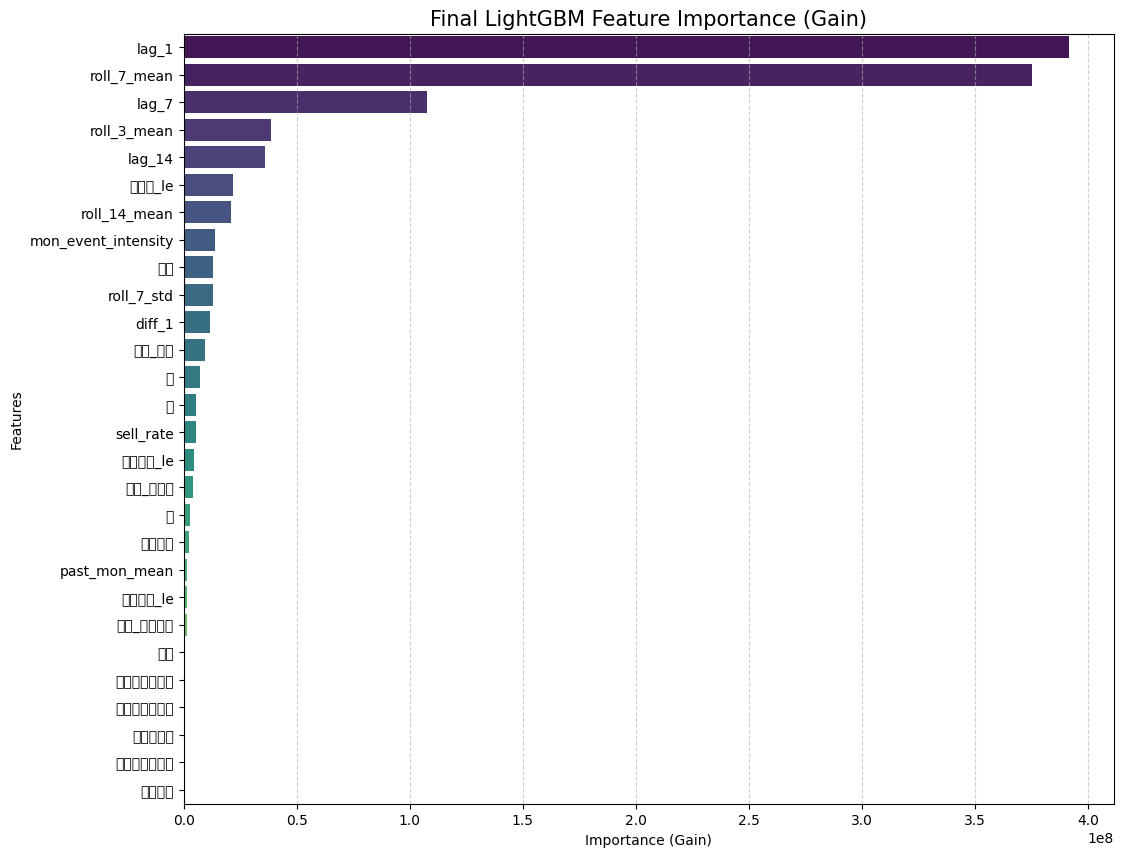

In [24]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 최적 하이퍼파라미터 설정 (Study 결과 반영)
best_params = study.best_trial.params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
best_params['verbosity'] = -1

# 2. 전체 데이터셋 준비 (시계열 정렬)
df_sorted = train_encoded.sort_values('영업일자')
X = df_sorted.drop(columns=[c for c in drop_cols if c in df_sorted.columns])
y = df_sorted['매출수량']

# 3. 최종 모델 학습
# categorical_feature를 다시 한번 명시하여 성능을 극대화합니다.
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(
    X, y,
    categorical_feature=[c for c in cat_features if c in X.columns]
)

# 4. 피처 중요도(Feature Importance) 데이터프레임 생성
# Gain 방식(모델의 결과에 기여한 총 이득)으로 확인하는 것이 더 정확합니다.
ft_importance_values = final_model.booster_.feature_importance(importance_type='gain')
ft_importance = pd.DataFrame(ft_importance_values, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

# 5. 시각화
plt.figure(figsize=(12, 10))
sns.barplot(x=ft_importance['Importance'], y=ft_importance.index, palette='viridis')
plt.title('Final LightGBM Feature Importance (Gain)', fontsize=15)
plt.xlabel('Importance (Gain)')
plt.ylabel('Features')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

lag_1, roll_7_mean 압도적(어제 판매량/최근 일주일 흐름)  
lag_7  
roll_3_mean, lag_14도  



In [25]:
# '영업장명'과 '영업장명_le' 사이의 관계 확인
mapping_df = train_encoded[['영업장명', '영업장명_le']].drop_duplicates().sort_values('영업장명_le')
print(mapping_df)

              영업장명  영업장명_le
0       느티나무 셀프BBQ        0
12236           담하        1
34580         라그로타        2
47880         미라시아        3
64372          연회장        4
76608        카페테리아        5
89376        포레스트릿        6
95760        화담숲주막        7
100016       화담숲카페        8


In [29]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. 평가용 데이터셋 다시 정의 (Optuna 밖에서 정의 필요)
df_sorted = train_encoded.sort_values('영업일자')
X = df_sorted.drop(columns=[c for c in drop_cols if c in df_sorted.columns])
y = df_sorted['매출수량']

# 시계열 순서에 따른 8:2 분할 (튜닝 시와 동일한 기준)
split_idx = int(len(X) * 0.8)
X_train, X_valid = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_valid = y.iloc[:split_idx], y.iloc[split_idx:]

# 2. 모델 평가 함수 (Weighted SMAPE 논리 반영)
def evaluate_resort_model(y_true, y_pred, df_valid):
    y_pred = np.maximum(y_pred, 0) # 음수 방지

    def calculate_smape(actual, predict):
        mask = (actual != 0) # 실제 매출이 0인 경우 제외
        a = actual[mask]
        p = predict[mask]
        if len(a) == 0: return 0
        return np.mean(2.0 * np.abs(a - p) / (np.abs(a) + np.abs(p))) * 100

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    overall_smape = calculate_smape(y_true, y_pred)

    print("="*50)
    print(f"🏠 전체 검증 세트 평가 결과")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"전체 SMAPE : {overall_smape:.4f}%")
    print("-" * 50)

    # 가중치 집중 관리 대상 (담하: 1, 미라시아: 3)
    high_weight_shops = {1: '담하 (High Weight)', 3: '미라시아 (High Weight)'}

    for le_val, name in high_weight_shops.items():
        shop_mask = df_valid['영업장명_le'] == le_val
        if shop_mask.sum() > 0:
            s_true = y_true[shop_mask.values]
            s_pred = y_pred[shop_mask.values]
            s_smape = calculate_smape(s_true, s_pred)
            print(f"📍 {name} 상세 지표")
            print(f"   - SMAPE: {s_smape:.4f}%")
    print("="*50)

# 3. 최종 예측 및 평가 실행
val_preds = final_model.predict(X_valid)
evaluate_resort_model(y_valid.values, val_preds, X_valid)

🏠 전체 검증 세트 평가 결과
MAE  : 5.0288
RMSE : 17.4569
전체 SMAPE : 50.8166%
--------------------------------------------------
📍 담하 (High Weight) 상세 지표
   - SMAPE: 53.5745%
📍 미라시아 (High Weight) 상세 지표
   - SMAPE: 48.7884%


MAE(5.02) vs RMSE(17.45): MAE에 비해 RMSE가 3배 이상 높습니다. 이는 대부분의 날에는 오차가 5개 내외로 적지만, 특정 성수기나 이벤트가 있는 날에 **대형 오차(Outlier)**가 발생하여 RMSE를 끌어올리고 있다는 뜻입니다. 히트맵에서 봤던 '포레스트릿'의 폭발적 수요 구간이 범인일 가능성이 큽니다.

담하(53.57%) vs 미라시아(48.78%): 가중치가 높은 두 업장의 SMAPE가 전체 평균(50.8%)과 비슷하거나 약간 높습니다. 특히 담하의 오차가 더 큰데, 이는 담하가 리조트 내 레스토랑으로서 계절이나 요일에 따른 '메뉴 Mix' 변화가 더 다채롭기 때문일 수 있습니다.


##XGBoost

In [30]:
import xgboost as xgb
import optuna
import numpy as np

# 1. 데이터 타입 최종 정리
# LGBM에서의 실수를 방지하기 위해 object 타입 재확인 및 변환
for col in cat_features:
    if col in train_encoded.columns:
        train_encoded[col] = train_encoded[col].astype('category')

# 2. 데이터 분할 (시계열 순서 유지)
df_sorted = train_encoded.sort_values('영업일자')
X = df_sorted.drop(columns=[c for c in drop_cols if c in df_sorted.columns])
y = df_sorted['매출수량']

split_idx = int(len(X) * 0.8)
X_train, X_valid = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_valid = y.iloc[:split_idx], y.iloc[split_idx:]

In [34]:
# 1. 숫자형 컬럼만 선택
numeric_cols = train_encoded.select_dtypes(include=[np.number]).columns

# 2. 숫자형 컬럼 내에 무한대(inf) 값이 있는지 확인
inf_check = np.isinf(train_encoded[numeric_cols]).any().any()
print("숫자형 컬럼 내 inf 값 존재 여부:", inf_check)

# 3. 무한대 값을 NaN으로 바꾼 후 0으로 채우기
# 전체 데이터프레임에 적용해도 숫자형에만 작동하므로 안전합니다.
train_encoded[numeric_cols] = train_encoded[numeric_cols].replace([np.inf, -np.inf], np.nan)
train_encoded[numeric_cols] = train_encoded[numeric_cols].fillna(0)

print("정제 후 inf 값 존재 여부:", np.isinf(train_encoded[numeric_cols]).any().any())

숫자형 컬럼 내 inf 값 존재 여부: True
정제 후 inf 값 존재 여부: False


In [35]:
def objective_xgb(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'eta': trial.suggest_float('eta', 0.01, 0.2),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'enable_categorical': True,
        'random_state': 42,
        'early_stopping_rounds': 50,
        'n_estimators': 1000
    }

    # 데이터 분할 시 무한대/결측치가 없는지 최종 확인된 데이터를 사용합니다.
    df_sorted = train_encoded.sort_values('영업일자')
    X = df_sorted.drop(columns=[c for c in drop_cols if c in df_sorted.columns])
    y = df_sorted['매출수량']

    split_idx = int(len(X) * 0.8)
    X_train, X_valid = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_valid = y.iloc[:split_idx], y.iloc[split_idx:]

    model = xgb.XGBRegressor(**param)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    preds = model.predict(X_valid)

    mask = y_valid != 0
    actual = y_valid[mask]
    predict = np.maximum(preds[mask], 0)

    smape_val = np.mean(2.0 * np.abs(actual - predict) / (np.abs(actual) + np.abs(predict))) * 100
    return smape_val

# 최적화 실행
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)

print('XGBoost 최적 파라미터:', study_xgb.best_trial.params)

[I 2026-01-28 14:59:05,724] A new study created in memory with name: no-name-e57bb585-9f06-4a22-8a95-72ab607dea73
[I 2026-01-28 14:59:11,596] Trial 0 finished with value: 64.11269971035289 and parameters: {'lambda': 6.396484558527554e-06, 'alpha': 0.06039769106227766, 'max_depth': 4, 'eta': 0.05731055751432143, 'gamma': 3.058955938609612e-07, 'colsample_bytree': 0.9740754223681802, 'subsample': 0.9339470737663429}. Best is trial 0 with value: 64.11269971035289.
[I 2026-01-28 14:59:15,574] Trial 1 finished with value: 55.24400071789063 and parameters: {'lambda': 2.9007144978423325e-05, 'alpha': 9.488890191703637e-06, 'max_depth': 11, 'eta': 0.16110894544530424, 'gamma': 0.0951344463584013, 'colsample_bytree': 0.7238698987070697, 'subsample': 0.669571528336191}. Best is trial 1 with value: 55.24400071789063.
[I 2026-01-28 14:59:18,789] Trial 2 finished with value: 65.01899708815584 and parameters: {'lambda': 6.852849116908229e-08, 'alpha': 0.00011936078637973235, 'max_depth': 4, 'eta': 0

XGBoost 최적 파라미터: {'lambda': 0.0037512300403679355, 'alpha': 0.01273042865595293, 'max_depth': 12, 'eta': 0.08806660136284676, 'gamma': 4.3302170511040755e-06, 'colsample_bytree': 0.6200778543687713, 'subsample': 0.8800513850062269}


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

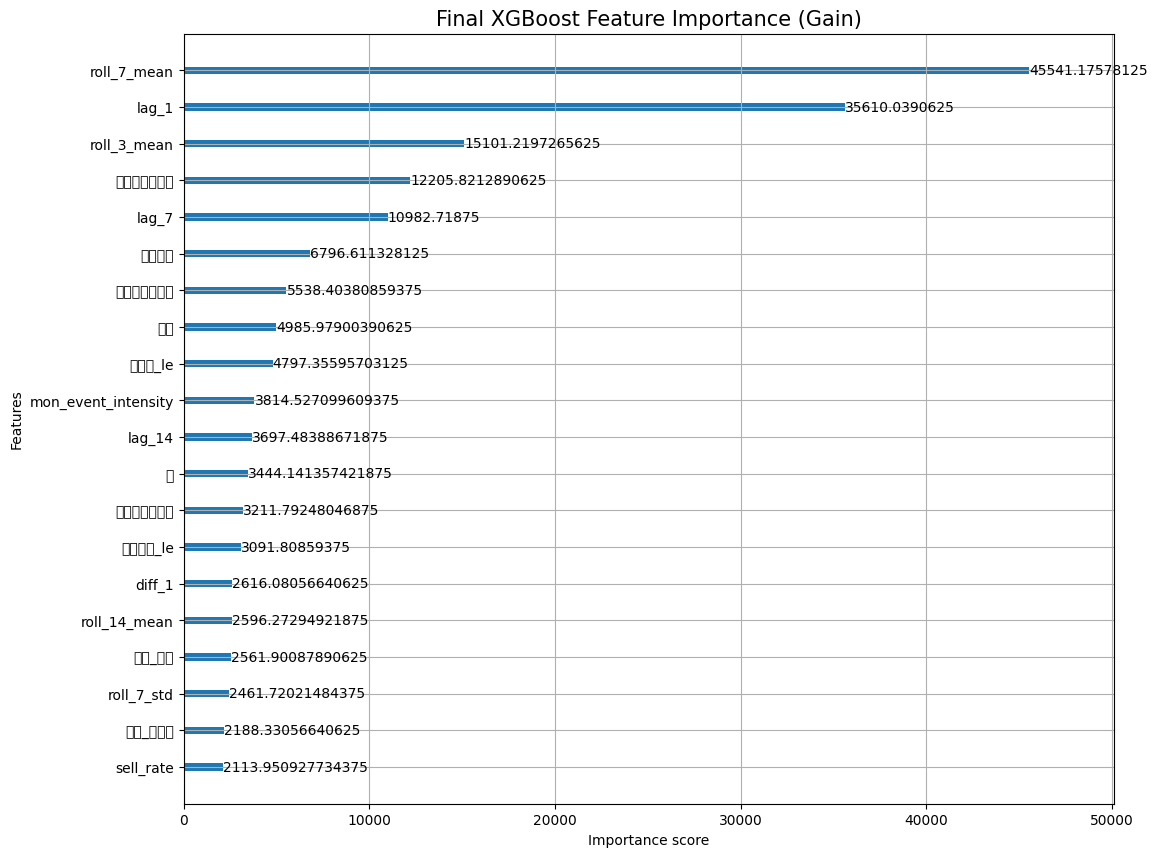

In [37]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. 학습용 데이터 다시 준비 및 inf/NaN 최종 제거
X = df_sorted.drop(columns=[c for c in drop_cols if c in df_sorted.columns])
y = df_sorted['매출수량']

# 숫자형 컬럼에 대해서만 inf 제거를 한 번 더 수행합니다.
numeric_cols_final = X.select_dtypes(include=[np.number]).columns
X[numeric_cols_final] = X[numeric_cols_final].replace([np.inf, -np.inf], np.nan).fillna(0)

# 2. 최적 파라미터 재설정 및 학습
# Optuna에서 찾은 파라미터를 사용합니다.
best_params_xgb = study_xgb.best_trial.params
best_params_xgb['objective'] = 'reg:squarederror'
best_params_xgb['random_state'] = 42
best_params_xgb['enable_categorical'] = True

final_model_xgb = xgb.XGBRegressor(**best_params_xgb)

# 3. 학습 실행 (여기서 에러가 나지 않아야 합니다)
final_model_xgb.fit(X, y)

# 4. 피처 중요도 시각화
plt.figure(figsize=(12, 10))
xgb.plot_importance(final_model_xgb, importance_type='gain', max_num_features=20, ax=plt.gca())
plt.title('Final XGBoost Feature Importance (Gain)', fontsize=15)
plt.show()

roll_7_mean
lag_1
roll_3_mean

In [38]:
# 검증 데이터셋 준비 (학습 때와 동일한 시점 분할)
split_idx = int(len(X) * 0.8)
X_valid = X.iloc[split_idx:]
y_valid = y.iloc[split_idx:]

# 예측 및 평가
xgb_val_preds = final_model_xgb.predict(X_valid)

print("="*20 + " [XGBoost] 최종 평가 결과 " + "="*20)
evaluate_resort_model(y_valid.values, xgb_val_preds, X_valid)

==================== [XGBoost] 최종 평가 결과 ====================
🏠 전체 검증 세트 평가 결과
MAE  : 1.5144
RMSE : 2.9392
전체 SMAPE : 45.5280%
--------------------------------------------------
📍 담하 (High Weight) 상세 지표
   - SMAPE: 46.3367%
📍 미라시아 (High Weight) 상세 지표
   - SMAPE: 48.3091%


XGBoost가 더 낫다

##Catboost

In [40]:
!pip install Catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.0 MB/s eta 0:00:00


In [41]:
from catboost import CatBoostRegressor, Pool
import optuna

# 1. 범주형 변수 리스트 지정 (인코딩 전 원본 문자열 컬럼을 써도 되지만, 여기서는 _le 컬럼 사용)
cat_features_idx = [X.columns.get_loc(c) for c in cat_features if c in X.columns]

def objective_cat(trial):
    param = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-2, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': 'Iter',
        'od_wait': 50,
        'verbose': False,
        'random_state': 42,
        'allow_writing_files': False
    }

    model = CatBoostRegressor(**param)

    # Catboost 전용 데이터 타입 Pool 사용
    train_pool = Pool(X_train, y_train, cat_features=cat_features_idx)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_idx)

    model.fit(train_pool, eval_set=valid_pool)

    preds = model.predict(X_valid)

    # 평가 산식: 실제값 0 제외 SMAPE
    mask = y_valid != 0
    actual = y_valid[mask]
    predict = np.maximum(preds[mask], 0)

    smape_val = np.mean(2.0 * np.abs(actual - predict) / (np.abs(actual) + np.abs(predict))) * 100
    return smape_val

study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=20) # Catboost는 학습 속도가 다소 느려 trial 조절 권장

print('Catboost 최적 파라미터:', study_cat.best_trial.params)

[I 2026-01-28 15:13:38,195] A new study created in memory with name: no-name-946b96e8-39bd-4452-9a8d-0795f798a299
[I 2026-01-28 15:14:31,185] Trial 0 finished with value: 62.52952974911143 and parameters: {'learning_rate': 0.07452740047811825, 'depth': 7, 'l2_leaf_reg': 0.0655867101840922, 'random_strength': 0.025478436178191035, 'bagging_temperature': 0.6081023755711807}. Best is trial 0 with value: 62.52952974911143.
[I 2026-01-28 15:15:57,111] Trial 1 finished with value: 61.12479896817242 and parameters: {'learning_rate': 0.07002368728879467, 'depth': 8, 'l2_leaf_reg': 0.015589235273370014, 'random_strength': 0.03532380164806587, 'bagging_temperature': 0.6812695927020525}. Best is trial 1 with value: 61.12479896817242.
[I 2026-01-28 15:18:07,573] Trial 2 finished with value: 62.75722252299427 and parameters: {'learning_rate': 0.058093094453624726, 'depth': 9, 'l2_leaf_reg': 1.7405686838446826, 'random_strength': 9.468506425285097, 'bagging_temperature': 0.8869682435095663}. Best is

Catboost 최적 파라미터: {'learning_rate': 0.085182307520681, 'depth': 8, 'l2_leaf_reg': 0.7946097406694248, 'random_strength': 0.010379641340966007, 'bagging_temperature': 0.8274485832799678}


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45684 (\N{HANGUL SYLLABLE NYU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loca

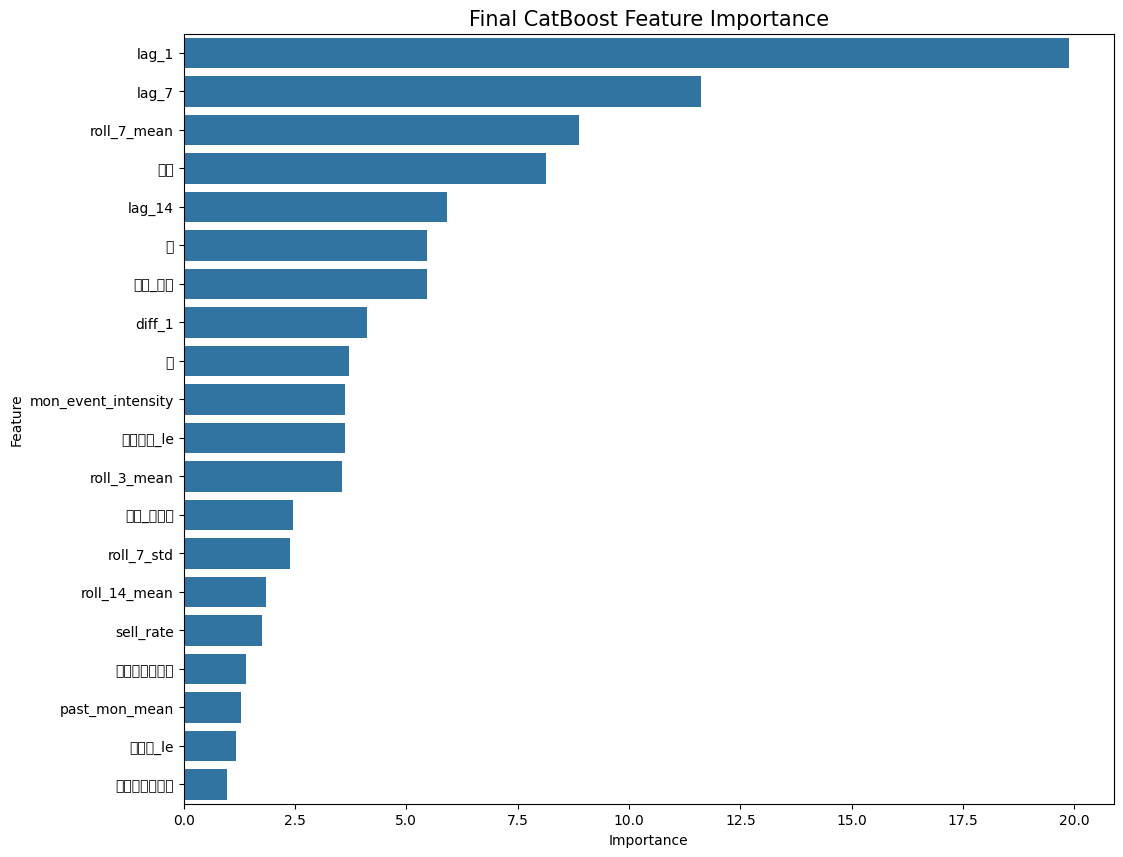

In [42]:
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

# 1. 최적 파라미터 설정
best_params_cat = study_cat.best_trial.params
best_params_cat['iterations'] = 1000
best_params_cat['random_state'] = 42
best_params_cat['od_type'] = 'Iter'
best_params_cat['od_wait'] = 50
best_params_cat['verbose'] = False

# 2. 최종 모델 학습
final_model_cat = CatBoostRegressor(**best_params_cat)
final_model_cat.fit(X, y, cat_features=cat_features_idx)

# 3. 피처 중요도 시각화
ft_imp_cat = final_model_cat.get_feature_importance()
ft_imp_df_cat = pd.DataFrame({'Feature': X.columns, 'Importance': ft_imp_cat}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=ft_imp_df_cat.head(20))
plt.title('Final CatBoost Feature Importance', fontsize=15)
plt.show()

lag_1, lag_7, roll_7_mean

In [43]:
# CatBoost 예측값 생성
cat_val_preds = final_model_cat.predict(X_valid)

print("="*20 + " [CatBoost] 최종 평가 결과 " + "="*20)
evaluate_resort_model(y_valid.values, cat_val_preds, X_valid)

==================== [CatBoost] 최종 평가 결과 ====================
🏠 전체 검증 세트 평가 결과
MAE  : 3.1725
RMSE : 9.2149
전체 SMAPE : 54.8928%
--------------------------------------------------
📍 담하 (High Weight) 상세 지표
   - SMAPE: 57.1790%
📍 미라시아 (High Weight) 상세 지표
   - SMAPE: 55.9859%


XGBoost가 제일 Good